In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
import os
import pickle
import plotly.express as px
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.tree import DecisionTreeClassifier

In [31]:
# Load dataset using KaggleHub
path = kagglehub.dataset_download("rupakroy/online-payments-fraud-detection-dataset")
file_path = os.path.join(path, "PS_20174392719_1491204439457_log.csv")
data = pd.read_csv(file_path)
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [32]:
# Exploratory data analysis
print(f"Dataset shape: {data.shape}")
print(data.info())

Dataset shape: (6362620, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB
None


* <font color='DarkOrange'>step</font> : represents a unit of time where 1 step equals 1 hour
* <font color='Pink'>type</font> : type of online transaction
* <font color='Orange'>amount</font> : the amount of the transaction
* <font color='Yellow'>nameOrig</font> : customer starting the transaction
* <font color='Purple'>oldbalanceOrg</font> : balance before the transaction
* <font color='Green'>newbalanceOrig</font> : balance after the transaction
* <font color='Brown'>nameDest</font> : recipient of the transaction
* <font color='Tomato'>oldbalanceDest</font> : initial balance of recipient before the transaction
* <font color='DarkKhaki'>newbalanceDest</font> : the new balance of recipient after the transaction
* <font color='red'>isFraud</font> : fraud transaction

In [33]:
# Searching for null values
data = data.dropna()
print(data.isnull().sum())

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


In [34]:
# Exploring transaction type
print(data.type.value_counts())

type
CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: count, dtype: int64


In [35]:
# Distribution of transaction types
type = data["type"].value_counts()
transactions = type.index
quantity = type.values

figure = px.pie(data,
                values=quantity,
                names=transactions, hole=0.5,
                title="Distribution of Transaction Type")
figure.show()

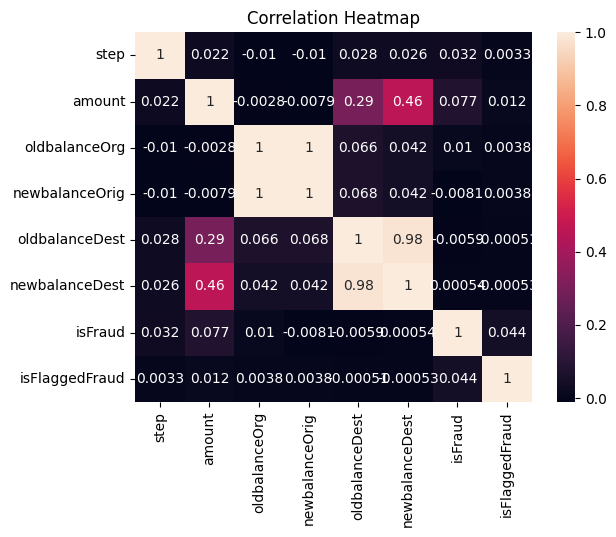

In [36]:
# Drop non-numeric columns for correlation calculation
numeric_data = data.select_dtypes(exclude=['object'])

# Calculate the correlation matrix
correlation = numeric_data.corr()
# Correlation heatmap
sns.heatmap(correlation, annot=True)
plt.title("Correlation Heatmap")
plt.show()


In [37]:
# Map transaction types to numerical values
data["type"] = data["type"].map({"CASH_OUT": 1, "PAYMENT": 2,
                                 "CASH_IN": 3, "TRANSFER": 4,
                                 "DEBIT": 5})
print(data.head())

   step  type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1     2   9839.64  C1231006815       170136.0       160296.36   
1     1     2   1864.28  C1666544295        21249.0        19384.72   
2     1     4    181.00  C1305486145          181.0            0.00   
3     1     1    181.00   C840083671          181.0            0.00   
4     1     2  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0  


In [38]:
# Update the feature set to include the 'amount' and engineered features
x = data[["type", "amount", "oldbalanceOrg", "newbalanceOrig"]].values
y = data["isFraud"].values


# Balance the dataset using oversampling
ros = RandomOverSampler(random_state=42)
x_balanced, y_balanced = ros.fit_resample(x, y)

# Train-test split after balancing
x_train, x_test, y_train, y_test = train_test_split(x_balanced, y_balanced, test_size=0.3, random_state=42, stratify=y_balanced)

# Check the class distribution in the training and test sets
print("Training class distribution:\n", pd.Series(y_train).value_counts())
print("Testing class distribution:\n", pd.Series(y_test).value_counts())

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning:

`BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning:

`BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.



Training class distribution:
 1    4448085
0    4448084
Name: count, dtype: int64
Testing class distribution:
 0    1906323
1    1906322
Name: count, dtype: int64


In [39]:
# Model training
model = DecisionTreeClassifier(ccp_alpha=0.01, max_features=3, min_samples_split=20, max_depth=5,random_state=42)
model.fit(x_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.01, max_depth=5, max_features=3,
                       min_samples_split=20, random_state=42)

Accuracy: 0.9615


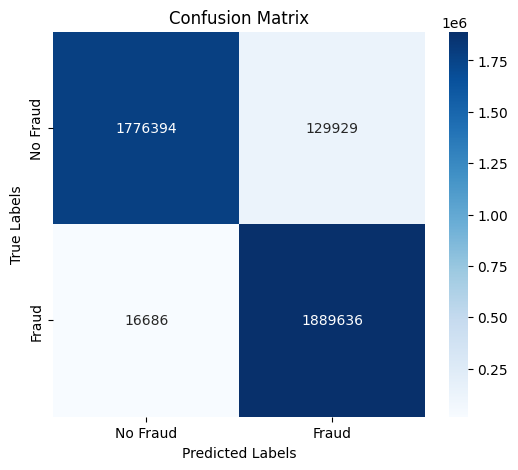

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.93      0.96   1906323
           1       0.94      0.99      0.96   1906322

    accuracy                           0.96   3812645
   macro avg       0.96      0.96      0.96   3812645
weighted avg       0.96      0.96      0.96   3812645



In [40]:
# Model evaluation
y_pred = model.predict(x_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["No Fraud", "Fraud"], yticklabels=["No Fraud", "Fraud"])
plt.title("Confusion Matrix")
plt.ylabel("True Labels")
plt.xlabel("Predicted Labels")
plt.show()

# Classification Report (includes Precision, Recall, F1-Score)
class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(class_report)

In [41]:
# Training accuracy
y_train_pred = model.predict(x_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f'Training Accuracy: {train_accuracy * 100:.2f}%')

Training Accuracy: 96.15%


In [42]:
# Save and load model
pickle.dump(model, open("model.pkl", "wb"))
model = pickle.load(open("model.pkl", "rb"))

In [43]:
y_pred = model.predict([[4, 181.00, 181.0, 0]])
y_pred_mapped = "Fraud" if y_pred[0] == 1 else "Not Fraud"

print(y_pred_mapped)


Fraud
